# Objective

This example implements the [XXX] model for image classification, and demonstrates it on the [XXX] dataset. 

# Installation of Packages

# Download Dataset from external source

# Importing packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

import time
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import  metrics
from tensorflow.keras import losses
from tensorflow.keras import utils
from tensorflow.keras import callbacks
from tensorflow.keras import ops
from tensorflow.keras import regularizers
from tensorflow.keras import initializers
from tensorflow.keras import applications
from tensorflow.keras import datasets
from tensorflow import keras


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay




print(tf.__version__) 

2.16.1


# Custom Functions

In [2]:
# Configuration
class Config:
    one_hot= True
    normalize= True
    tf_data= False
    epochs = 10
    

In [3]:
def seed_everything(seed=42):
    # Seed value for TensorFlow
    tf.random.set_seed(seed)
    
    # Seed value for NumPy
    np.random.seed(seed)
    
    # Seed value for Python's random library
    random.seed(seed)
    
    # Force TensorFlow to use single thread
    # Multiple threads are a potential source of non-reproducible results.
    session_conf = tf.compat.v1.ConfigProto(
        intra_op_parallelism_threads=1,
        inter_op_parallelism_threads=1
    )

    # Make sure that TensorFlow uses a deterministic operation wherever possible
    tf.compat.v1.set_random_seed(seed)

    

In [4]:
seed_everything()

In [5]:
def get_target(name):
    if name == 'mnist':
        return ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'] 
    elif name == 'cifar10':
        return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'] 


class_names = get_target('cifar10')

# Reading Data

In [6]:
#Available Dataset: cifar10, cifar100, mnist

(x_train, y_train), (x_test, y_test) =  datasets.cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


# Data Inspection / Visualization

In [7]:
pd.DataFrame({
    'Class': ['Train', 'Test'], 
    'Data Size': [len(x_train),  len(x_test)],
    'Features Shape': [x_train.shape[1:], x_test.shape[1:]], 
    'Target Shape': [y_train.shape,  y_test.shape] })

,Class,Data Size,Features Shape,Target Shape
0,Train,50000,"(32, 32, 3)","(50000, 1)"
1,Test,10000,"(32, 32, 3)","(10000, 1)"


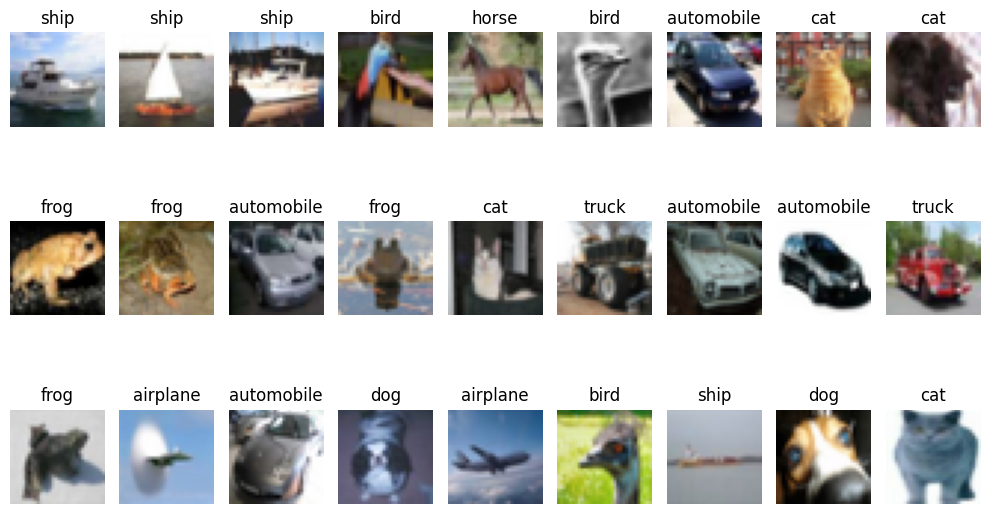

In [8]:
plt.figure(figsize=(10,8))
numRows = x_train.shape[0]
randomIndex = np.random.randint(0, numRows, 27)
for i in range(27):
    plt.subplot(4, 9, i+1)
    item = x_train[int(randomIndex[i])]
    plt.imshow(item) 
    plt.title(class_names[int(y_train[int(randomIndex[i])])])
    plt.axis(False)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)


plt.tight_layout()

# Data Preprocessing

In [9]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=0)

In [10]:
pd.DataFrame({
    'Class': ['Train', 'Val', 'Test'], 
    'Data Size': [len(x_train), len(x_val), len(x_test)],
    'Features Shape': [x_train.shape[1:], x_val.shape[1:], x_test.shape[1:]], 
    'Target Shape': [y_train.shape, y_val.shape, y_test.shape] })

,Class,Data Size,Features Shape,Target Shape
0,Train,45000,"(32, 32, 3)","(45000, 1)"
1,Val,5000,"(32, 32, 3)","(5000, 1)"
2,Test,10000,"(32, 32, 3)","(10000, 1)"


In [11]:
num_classes = len(np.unique(y_train))
input_shape = x_train.shape[1:]

print('num of classes :', num_classes)
print('input shape :', input_shape)

num of classes : 10
input shape : (32, 32, 3)


In [12]:
# Hyper-parameterization 


In [13]:
# Normalization
if Config.normalize:
    # Convert pixel values data type to float32
    x_train = x_train.astype('float32')
    x_test  = x_test.astype('float32')
    x_val = x_val.astype('float32')

    # Calculate the mean and standard deviation of the training images
    mean = np.mean(x_train)
    std  = np.std(x_train)

    # Normalize the data
    # The tiny value 1e-7 is added to prevent division by zero
    x_train = (x_train-mean)/(std+1e-7)
    x_test  = (x_test-mean) /(std+1e-7)
    x_val = (x_val-mean)/(std+1e-7)

In [14]:
if Config.one_hot:
    # Convert to Categorical
    y_train = utils.to_categorical(y_train, num_classes)
    y_val = utils.to_categorical(y_val, num_classes)
    y_test = utils.to_categorical(y_test, num_classes)

   

In [15]:
pd.DataFrame({
        'Class': ['Train', 'Val', 'Test'],
        'Features Shape': [x_train.shape, x_val.shape, x_test.shape], 
        'Target Shape': [y_train.shape, y_val.shape, y_test.shape]}
        )

,Class,Features Shape,Target Shape
0,Train,"(45000, 32, 32, 3)","(45000, 10)"
1,Val,"(5000, 32, 32, 3)","(5000, 10)"
2,Test,"(10000, 32, 32, 3)","(10000, 10)"


In [16]:
# data_generator = ImageDataGenerator(
#     # Rotate images randomly by up to 15 degrees
#     rotation_range=15,
    
#     # Shift images horizontally by up to 12% of their width
#     width_shift_range=0.12,
    
#     # Shift images vertically by up to 12% of their height
#     height_shift_range=0.12,
    
#     # Randomly flip images horizontally
#     horizontal_flip=True,
    
#     # Zoom images in by up to 10%
#     zoom_range=0.1,
    
#     # Change brightness by up to 10%
#     brightness_range=[0.9,1.1],

#     # Shear intensity (shear angle in counter-clockwise direction in degrees)
#     shear_range=10,
    
#     # Channel shift intensity
#     channel_shift_range=0.1,
# )

data_augmentation = models.Sequential(
    [
        layers.Normalization(),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.1),
        layers.RandomContrast(factor=0.1),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [17]:
def to_tf_datasets(images, labels, is_train=False):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    if is_train:
        dataset = dataset.shuffle(batch_size * 10)
    dataset = dataset.batch(batch_size)
    if is_train:
        dataset = dataset.map(
            lambda x, y: (data_augmentation(x), y), num_parallel_calls=tf.data.AUTOTUNE
        )
    return dataset.prefetch(tf.data.AUTOTUNE)

In [18]:
if Config.tf_data:
    train_dataset = to_tf_datasets(x_train, y_train, is_train=True)
    val_dataset = to_tf_datasets(x_val, y_val)
    test_dataset = to_tf_datasets(x_test, y_test)


In [19]:
# print(train_dataset)
# print(val_dataset)
# print(test_dataset)

# Data Postprocessing

# Model

In [20]:
def custom_model(input_shape=input_shape):
    # Initialize a sequential model
    model = models.Sequential()

    # Set the weight decay value for L2 regularization
    weight_decay = 0.0001
    model.add(layers.Input(shape=input_shape))
    # Add the first convolutional layer with 32 filters of size 3x3
    model.add(layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay), 
                    input_shape=input_shape))
    # Add batch normalization layer
    model.add(layers.BatchNormalization())

    # Add the second convolutional layer similar to the first
    model.add(layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(layers.BatchNormalization())

    # Add the first max pooling layer with pool size of 2x2
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    # Add dropout layer with 0.2 dropout rate
    model.add(layers.Dropout(rate=0.2))

    # Add the third and fourth convolutional layers with 64 filters
    model.add(layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))   
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(layers.BatchNormalization())

    # Add the second max pooling layer and increase dropout rate to 0.3
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(rate=0.3))

    # Add the fifth and sixth convolutional layers with 128 filters
    model.add(layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay))) 
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(layers.BatchNormalization())

    # Add the third max pooling layer and increase dropout rate to 0.4
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(rate=0.4))

    # Add the seventh and eighth convolutional layers with 256 filters
    model.add(layers.Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay))) 
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(layers.BatchNormalization())

    # Add the fourth max pooling layer and increase dropout rate to 0.5
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(rate=0.5))

    # Flatten the tensor output from the previous layer
    model.add(layers.Flatten())

    # Add a fully connected layer with softmax activation function for outputting class probabilities
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

# Training

In [21]:
def run_experiment(model,  batch_size = 0):
    weight_decay = 0.003
    
    if Config.one_hot:
        model.compile(
                loss=keras.losses.CategoricalCrossentropy(),
                optimizer=keras.optimizers.AdamW(learning_rate=0.0005, weight_decay=weight_decay ),
                metrics=[
                    keras.metrics.CategoricalAccuracy(name="accuracy"),
                    keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
                ],
            )
    else:
        model.compile(
            optimizer=keras.optimizers.AdamW(learning_rate=0.0005, weight_decay=weight_decay ),
            loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True ),
            metrics=[
                keras.metrics.CategoricalAccuracy(name="accuracy"),
                ],
        )

     

    callback=[
        callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001),
        callbacks.EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True, verbose=1),
        callbacks.ModelCheckpoint("/tmp/checkpoint.keras",monitor="val_accuracy",save_best_only=True,save_weights_only=False,)
    ]

 
    if Config.tf_data:
        history = model.fit(
            train_dataset,
            validation_data=val_dataset,
            batch_size=batch_size,
            epochs=Config.epochs,
            callbacks=callback,
        )
        evaluation= model.evaluate(test_dataset, return_dict=True)

    else:
        history = model.fit(
                x_train, y_train, 
                epochs=Config.epochs,
                validation_data=(x_val, y_val),
                #callbacks=callbacks, 
            )
        
        evaluation= model.evaluate(x_val,y_val, return_dict=True)
    
    

    return history, model, evaluation

In [22]:
model = custom_model()

In [23]:
history, model, evaluation = run_experiment(model, batch_size=0)

Epoch 1/10


I0000 00:00:1734226379.367410      95 service.cc:145] XLA service 0x792034002480 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734226379.367467      95 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734226379.367473      95 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  18/1407 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.1384 - loss: 4.7284 - top-5-accuracy: 0.5691 

I0000 00:00:1734226389.867572      95 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 36s 15ms/step - accuracy: 0.3051 - loss: 2.7188 - top-5-accuracy: 0.8117 - val_accuracy: 0.5268 - val_loss: 1.3881 - val_top-5-accuracy: 0.9428
Epoch 2/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5279 - loss: 1.5309 - top-5-accuracy: 0.9379 - val_accuracy: 0.6410 - val_loss: 1.1215 - val_top-5-accuracy: 0.9708
Epoch 3/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.6259 - loss: 1.2045 - top-5-accuracy: 0.9633 - val_accuracy: 0.6914 - val_loss: 0.9906 - val_top-5-accuracy: 0.9790
Epoch 4/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.6817 - loss: 1.0288 - top-5-accuracy: 0.9768 - val_accuracy: 0.7290 - val_loss: 0.9308 - val_top-5-accuracy: 0.9832
Epoch 5/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.7294 - loss: 0.9222 - top-5-accuracy: 0.9813 - val_accuracy: 0.7514 - val_loss: 0.8927 - val_top-5-accuracy: 0.9858
Epoch 6/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.7542 - loss: 0.8586 -

In [24]:
#utils.plot_model(model, show_shapes=True)
#model.summary()

# Evaluation

In [25]:
def read_metrics():
    metric_holder=[mertic for mertic in evaluation.keys() ]
    value_holder = [round(value,2) for value in evaluation.values()]

    return pd.DataFrame({'Metrics':metric_holder, 'Value': value_holder})

evals = read_metrics()
evals

,Metrics,Value
0,accuracy,0.82
1,loss,0.76
2,top-5-accuracy,0.99


In [26]:
if Config.tf_data:
    predictions = model.predict(test_dataset)
else:
     predictions = model.predict(x_test)

predicted_class = np.argmax(predictions, axis=1)


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


<Axes: >

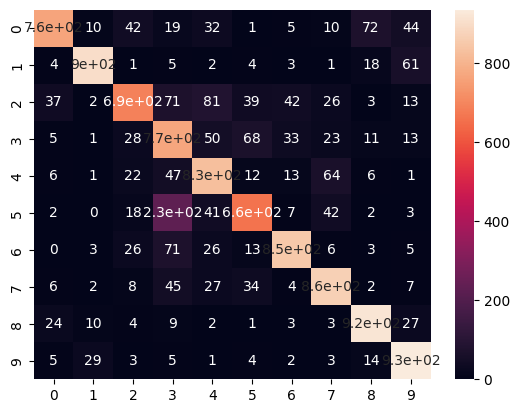

In [27]:
cm = confusion_matrix(np.argmax(y_test, axis=1), predicted_class)
sns.heatmap(cm, annot=True)

In [28]:
def make_plot(metric):
  plt.plot(history.history[metric ], color='#8502d1')
  plt.plot(history.history['val_'+metric ], color='darkorange')
  plt.title( 'Model '+metric )
  plt.ylabel( metric.capitalize() )
  plt.xlabel( 'Epoch' )
  plt.legend([ 'Train' , 'Validation' ], loc='upper left' )
  plt.show()

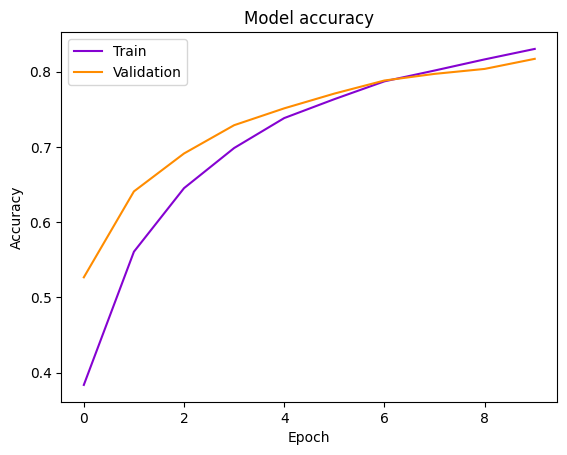

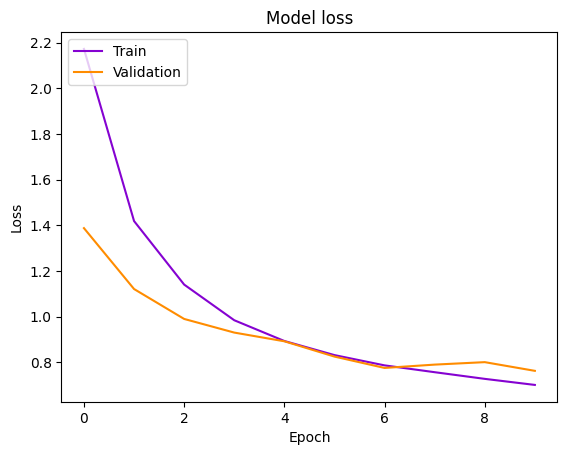

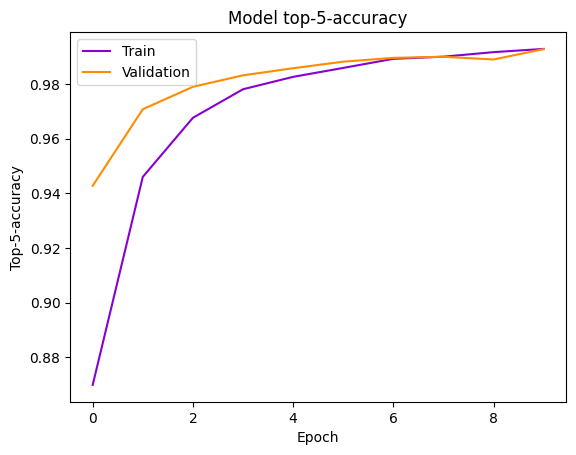

In [29]:
for i in evals['Metrics']:
    make_plot(i) 

# Texting

Text(0.5, 1.0, 'Predicted Class: frog \n Actual Class: airplane')

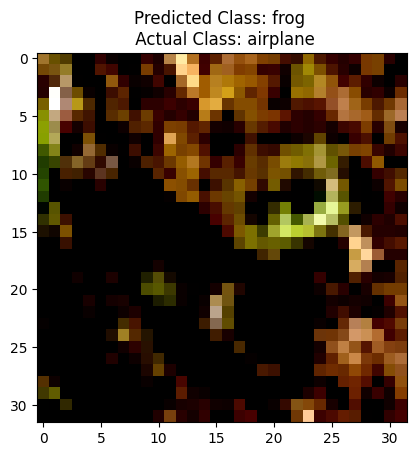

In [44]:
item_pos = np.random.randint(0, len(x_test), 1)
plt.imshow(x_test[item_pos][0])
plt.title(f"Predicted Class: {class_names[int(predicted_class[item_pos])]} \n Actual Class: {class_names[np.argmax(y_test[3], axis=0)]}")

# Deploy

In [31]:
#model.save("custom_image_classification_model")

# Inference